## Summary of the notebook

## Mount the drive

In [1]:
# mount the drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Setting the correct path

In [2]:
import os


project_path = '/content/drive/MyDrive/MasterThesis'
task_name = 'CaliforniaHousingDatasetTests'
exp_name = 'GBP_explanation'
uncert_name = 'flipout'

%cd /content/drive/MyDrive/MasterThesis/ 

print(os.getcwd())
path = project_path + '/' + task_name + '/' + exp_name + '/' + uncert_name + '/' # 'CaliforniaHousingDatasetTests/GBP_explanation/flipout/'
print('project path ', path)

saved_model_path =  os.path.join(path, 'saved_models')
print('saved_model_path ', saved_model_path)

explanation_path = os.path.join(os.path.dirname(path), 'explanation_files')
explanation_heatmap_path = os.path.join(os.path.dirname(path), 'explanation_heatmaps')

print('explanation_path ', explanation_path)
print('explanation_heatmap ', explanation_heatmap_path)

/content/drive/MyDrive/MasterThesis
/content/drive/MyDrive/MasterThesis
project path  /content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/flipout/
saved_model_path  /content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/flipout/saved_models
explanation_path  /content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/flipout/explanation_files
explanation_heatmap  /content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/flipout/explanation_heatmaps


## Removing previous plots and explanations

In [3]:
#import glob, os, os.path
#output_plot_path = path+'output_plots/'
#filelist_pdf = glob.glob(os.path.join(output_plot_path, '*.pdf'))
#filelist_png = glob.glob(os.path.join(output_plot_path, '*.png'))

# removing pdf explanations
#for f in filelist_pdf:
#    print(f'removing file {f}')
#    os.remove(f)

#for f in filelist_png:
#    print(f'removing file {f}')
#    os.remove(f)

## Imports

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm 

import time 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import tensorflow as tf
import keras

import os
import random 
import math

import seaborn as sns 

from keras.layers import *
from keras.models import Model, Sequential
import keras.backend as K

#tf.compat.v1.disable_eager_execution()
print(tf.__version__)
print(f'Eager execution enabled : {tf.executing_eagerly()}')

import sys
sys.path.insert(0,'/content/drive/My Drive/MasterThesis/src/')

from utils import *

2.8.2
Eager execution enabled : True


## Load data

In [5]:
train_data, train_labels, val_data, val_labels, test_data, test_labels, feature_names = load_california_housing_data()
#print(train_labels[20])
#print(val_labels[30])
#print(test_labels[40])

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
Training data shape 
 (12750, 8)
Training labels shape 
 (12750, 1)
Validation data shape 
  (4250, 8)
Validation labels shape 
  (4250, 1)
Test data shape 
  (3000, 8)
Test labels shape 
  (3000, 1)


## Class definition

### StochasticModel & StochasticRegressor

In [6]:
import numpy as np
import tensorflow as tf 
import tensorflow.keras.backend as K 

Layer = tf.keras.layers.Layer
Dropout = tf.keras.layers.Dropout


class StochasticModel:
    """
        Stochastic model, requiring several forward passes to produce an estimate of the posterior predictive distribution.
        This class just wraps a keras model to enable dropout at inference time.
    """
    def __init__(self, model, num_samples=10, **kwargs):
        """
            Builds a stochastic model from a keras model. The model should already be trained.
        """
        self.model = model
        self.num_samples = num_samples
    
    def predict_samples(self, x, num_samples=None, batch_size=32, multi_output=False, **kwargs):
        """
            Performs num_samples predictions using the model, and returns the produced output samples.
        """

        if num_samples is None:
            num_samples = self.num_samples

        assert num_samples > 0
        samples = [None] * num_samples

        if "verbose" not in kwargs:
            kwargs["verbose"] = 0

        for i in range(num_samples):
            samples[i] = self.model.predict(x, batch_size=1, **kwargs)

        if multi_output:
            return samples
        else:
            return np.array(samples)
            
            
class  StochasticRegressor(StochasticModel):
    def __init__(self, model, num_samples=10, **kwargs):
        # https://stackoverflow.com/questions/62280161/saving-keras-models-with-custom-layers
        super().__init__(model, num_samples)
        self.input = self.model.input
        self.output = self.model.output

    def predict_output(self, inp, num_samples=None, batch_size=32, output_scaler=None, **kwargs):
        """
            Performs a prediction  given input inp using MC Dropout, and returns the mean and standard deviation of the model output.
        """
        samples = self.predict_samples(inp, num_samples, batch_size=batch_size, **kwargs)
        print('Intermediate samples shape ', samples.shape)

        if output_scaler is not None:
            samples = list(map(lambda x: output_scaler.inverse_transform(x), samples))

        mean_pred = np.mean(samples, axis=0)
        std_pred = np.std(samples, axis=0)

        return samples, mean_pred, std_pred 

    def save(self, path):
        # stochaticmodel class does not have basic tf function like save(), summary(), get_layer() and so on 
        # https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object
        self.model.save(path)

    def summary(self):
        return self.model.summary()  

    def evaluate(self, test_data):
        return self.model.evaluate(test_data)

    def get_layer(self, name=None, index=None):
        # the get_layer() has been taken from ths following source 
        # https://github.com/keras-team/keras/blob/v2.8.0/keras/engine/training.py#L2797-L2831
    
        """Retrieves a layer based on either its name (unique) or index.
        If `name` and `index` are both provided, `index` will take precedence.
        Indices are based on order of horizontal graph traversal (bottom-up).
        Args:
            name: String, name of layer.
            index: Integer, index of layer.
        Returns:
            A layer instance.
        """
        # TODO(fchollet): We could build a dictionary based on layer names
        # since they are constant, but we have not done that yet.
        if index is not None and name is not None:
            raise ValueError('Provide only a layer name or a layer index. Received: '
                        f'index={index}, name={name}.')

        if index is not None:
            if len(self.layers) <= index:
                raise ValueError(f'Was asked to retrieve layer at index {index}'
                            f' but model only has {len(self.layers)}'
                            ' layers.')
            else:
                return self.model.layers[index]

        if name is not None:
            for layer in self.model.layers:
                if layer.name == name:
                    return layer
            raise ValueError(f'No such layer: {name}. Existing layers are: '
                        f'{list(layer.name for layer in self.model.layers)}.')
        raise ValueError('Provide either a layer name or layer index at '
                     '`get_layer`.')

### Gaussian and Rademacher distribution

In [7]:
# rademacher 
import tensorflow.keras.backend as K

def sample(shape):
    samples = K.random_binomial(shape, p=0.5)

    return 2.0 * samples - 1.0


# gaussian 
import numpy as np
import math

NegHalfLog2PI = -0.5 * math.log(2.0 * math.pi)
InvSqrt2PI = 1.0 / (math.sqrt(2.0 * math.pi))

def log_probability(x, mu, sigma):
    return NegHalfLog2PI - K.log(sigma) - 0.5 * K.square((x - mu) / sigma)

def probability(x, mu, sigma):
    x= K.square((x - mu) / sigma)

    return InvSqrt2PI * (1.0 / sigma) * K.exp(-0.5 * x)

class GaussianDistribution:
    def __init__(self, mean, std, shape):
        self.mean = mean
        self.std = std
        self.shape = shape

    def sample(self):
        return K.random_normal(self.shape, self.mean, self.std)

    def sample_perturbation(self):
        return K.random_normal(self.shape, K.zeros(self.shape), self.std)

    def log_probability(self, x):
        return NegHalfLog2PI - K.log(self.std) - 0.5 * K.square((x - self.mean) / self.std)

### FlipoutDense

In [8]:
import numpy as np
import tensorflow 
import keras.backend as K
Layer = keras.layers.Layer
activations = tensorflow.keras.activations
initializers = keras.initializers

#from keras_uncertainty.distributions import gaussian, rademacher

# Code partially based on http://krasserm.github.io/2019/03/14/bayesian-neural-networks/

class FlipoutDense(Layer):
    def __init__(self,
                 units,
                 kl_weight,
                 activation=None,
                 initializer_sigma=0.1,
                 prior=True,
                 prior_sigma_1=1.5,
                 prior_sigma_2=0.1,
                 prior_pi=0.5,
                 prior_pi_1=None,
                 prior_pi_2=None,
                 bias_distribution=False,
                  **kwargs):
        #print('inside flipoutdense __init__()')
        self.units = units
        self.kl_weight = kl_weight
        self.activation = activations.get(activation)
        self.prior = prior
        self.prior_sigma_1 = prior_sigma_1
        self.prior_sigma_2 = prior_sigma_2
        self.prior_pi_1 = prior_pi
        self.prior_pi_2 = 1.0 - prior_pi
        self.initializer_sigma = initializer_sigma
        self.uses_learning_phase = True
        self.bias_distribution = bias_distribution

        super().__init__(**kwargs)

    def compute_output_shape(self, input_shape):
        return [(None, self.units)]

    def build(self, input_shape):
        self.kernel_mu = self.add_weight(name='kernel_mu',
                                         shape=(input_shape[1], self.units),
                                         initializer=initializers.normal(stddev=self.initializer_sigma),
                                         trainable=True)
        
        self.kernel_rho = self.add_weight(name='kernel_rho',
                                          shape=(input_shape[1], self.units),
                                          initializer=initializers.normal(mean=-3.0, stddev=self.initializer_sigma),
                                          trainable=True)

        self.bias_mu = self.add_weight(name='bias_mu',
                                       shape=(self.units,),
                                       initializer=initializers.normal(stddev=self.initializer_sigma),
                                       trainable=True)

        self.bias_rho = self.add_weight(name='bias_rho',
                                        shape=(self.units,),
                                        initializer=initializers.normal(mean=-3.0, stddev=self.initializer_sigma),
                                        trainable=self.bias_distribution)
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        kernel_sigma = K.softplus(self.kernel_rho)
        kernel_perturb = kernel_sigma * K.random_normal(self.kernel_mu.shape)
        kernel = self.kernel_mu + kernel_perturb

        if self.bias_distribution:
            bias_sigma = K.softplus(self.bias_rho)
            bias = self.bias_mu + bias_sigma * K.random_normal(self.bias_mu.shape)
        else:
            bias = self.bias_mu

        loss = self.kl_loss(kernel, self.kernel_mu, kernel_sigma)

        if self.bias_distribution:
            loss += self.kl_loss(bias, self.bias_mu, bias_sigma)

        self.add_loss(K.in_train_phase(loss, 0.0))

        input_shape = K.shape(inputs)
        batch_shape = input_shape[:-1]
        sign_input = sample(input_shape)
        sign_output = sample(K.concatenate([batch_shape, K.expand_dims(self.units, 0)], axis=0))
        perturbed_inputs = K.dot(inputs * sign_input, kernel_perturb) * sign_output

        outputs = K.dot(inputs, self.kernel_mu)
        outputs += perturbed_inputs
        outputs += bias

        # This always produces stochastic outputs
        return self.activation(outputs)

    def kl_loss(self, w, mu, sigma):
        return self.kl_weight * K.mean(log_probability(w, mu, sigma) - self.prior * self.log_prior_prob(w))

    def log_prior_prob(self, w):
        return K.log(self.prior_pi_1 * probability(w, 0.0, self.prior_sigma_1) +
                     self.prior_pi_2 * probability(w, 0.0, self.prior_sigma_2))

    def get_config(self):
        config = {'units': self.units,
                  'kl_weight': self.kl_weight,
                  'activation': self.activation.__name__,
                  #'bias': self.bias,
                  'prior': self.prior,
                  'prior_sigma_1': self.prior_sigma_1,
                  'prior_sigma_2': self.prior_sigma_2,
                  'prior_pi_1': self.prior_pi_1}
        base_config = super(FlipoutDense, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

## Vanilla model (just for visualization)

In [9]:
model = Sequential()
model.add(Input(shape=(8, )))

model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
   
model.add(Dense(1, activation='relu'))

model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dense_2 (Dense)             (None, 8)                 72        
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________


## Load the saved models

In [10]:
# slightly different procedure to load the ensemble model from yaml file 

import os


#dir_name = '/content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/deep_ensemble/'
#test = os.listdir(dir_name)

#for item in test:
#    if '.h5' in item:
#        dir = dir_name+item
#        with open(dir+'/model_as_json.json', 'r') as json_file:
#            json_savedModel=json_file.read()
#        model = tf.keras.models.model_from_json(json_savedModel)

#model.summary()

# reference : https://towardsdatascience.com/saving-and-loading-keras-model-42195b92f57a



print(saved_model_path)
for item in os.listdir(saved_model_path):
    if '.h5' in item:
        print(item)
        model = tf.keras.models.load_model(os.path.join(saved_model_path, item), custom_objects={'FlipoutDense':FlipoutDense})
        

model.summary()

/content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/flipout/saved_models
model_epochs_500_num_samples_20.h5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dense_2 (Dense)             (None, 8)                 72        
                                                                 
 flipout_dense (FlipoutDense  (None, 1)                18        
 )                                                               
                                                                 
Total params: 234
Trainable params: 233
Non-trainable params: 1
____________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


## Prediction on test set

In [11]:
# Analysis of the input 
'''
num_of_inputs_to_be_explained = 1

start_index = np.random.randint(0, test_data.shape[0])
print('start_index : ', start_index)

test_input = test_data[start_index:start_index+num_of_inputs_to_be_explained]
print('test_input shape :', test_input.shape)

test_input_adj = np.expand_dims(test_input, axis=-1)
print('test_input_adj shape :', test_input_adj.shape)
'''

# MODEL PREDICTION AND PLOTTING 
num_samples=10
stochastic_model = StochasticRegressor(model, num_samples=num_samples)
pred_samples, pred_mean, pred_std = stochastic_model.predict_output(test_data)

print('test_labels \n ', test_labels)
print('pred_mean \n ', pred_mean)

mse_test_set = np.mean((test_labels - pred_mean)**2, axis=1)

print('mse test set ', mse_test_set)
print('mse test set shape ', mse_test_set.shape)

# ascending order (last 5 values will be the worst predictions)
sorted_mse_test_set = sorted(mse_test_set)

print('sorted_mse_test_set \n ', sorted_mse_test_set)
print('max sorted_mse_test_set \n ', np.max(sorted_mse_test_set))
print('min sorted_mse_test_set \n ', np.min(sorted_mse_test_set))

#sorted_mse_test_set_index = [list(mse_test_set).index(i) for i in sorted_mse_test_set]
#print('sorted_mse_test_set_index \n ', sorted_mse_test_set_index)


#difficulty = 'easy'
#number_of_most_extreme_inputs_to_be_analysed = 20

#if difficulty == 'difficult':
#    index_of_most_extreme_inputs_to_predict = sorted_mse_test_set_index[-number_of_most_extreme_inputs_to_be_analysed:]
#    print('sorted (ascending order of difficulty) index of most difficult inputs to predict : \n', index_of_most_extreme_inputs_to_predict)

#elif difficulty == 'easy':
#    index_of_most_extreme_inputs_to_predict = sorted_mse_test_set_index[:number_of_most_extreme_inputs_to_be_analysed]
#    print('sorted (ascending order of difficulty) index of most easy inputs to predict : \n', index_of_most_extreme_inputs_to_predict)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


Intermediate samples shape  (10, 3000, 1)
test_labels 
  [[0.67476298]
 [0.32251241]
 [0.51937064]
 ...
 [0.08272234]
 [0.2931931 ]
 [1.        ]]
pred_mean 
  [[0.72335386]
 [0.41594467]
 [0.55235785]
 ...
 [0.19213572]
 [0.26265284]
 [1.045907  ]]
mse test set  [0.00236107 0.00872959 0.00108816 ... 0.01197129 0.00093271 0.00210745]
mse test set shape  (3000,)
sorted_mse_test_set 
  [3.0685295866627387e-11, 1.5849973432220583e-09, 2.266866608922939e-09, 1.0967945410070001e-08, 4.754464483825609e-08, 1.0580994493756132e-07, 1.7250987035340079e-07, 3.154867495744657e-07, 3.2106200221240256e-07, 4.0820795676105934e-07, 7.774362560526416e-07, 9.089743956197182e-07, 9.285997142847802e-07, 9.83337308268386e-07, 1.0060832858333957e-06, 1.1364614801468125e-06, 1.234427155526303e-06, 1.6788523006217926e-06, 1.9178900826069263e-06, 1.94723376541092e-06, 2.249732018571903e-06, 2.255392059969265e-06, 2.5832967095153697e-06, 2.6146341745576594e-06, 2.640753934227084e-06, 2.7632801062242587e-06, 2.

## Identifying extreme inputs

In [12]:
#list_of_gt = [] 

#print('input features :\n', feature_names)

#for i in index_of_most_extreme_inputs_to_predict:
#    print(f'features for input # {i}: \n', test_data[i, :])
#    print(f'output gt for input # {i} : \n', test_labels[i])
#    list_of_gt.append(test_labels[i])

## GT vs prediction visualization for selected points

start_index 
  851
random range 
  range(0, 100)
test labels plot 
  [0.67476298 0.32251241 0.51937064 0.64397771 0.1239788  0.09319352
 0.09319352 0.30240774 0.35999925 0.29675331 0.21465924 0.07497366
 0.48188381 0.43706715 0.41884729 0.27350728 0.33256475 0.24083719
 0.58115062 0.82052184 0.21738174 0.127539   0.45863778 0.19455457
 0.26848111 0.96795609 0.47643879 0.72607178 0.68586244 0.84293017
 0.17403105 0.31434489 0.22282676 0.24984241 0.33780034 0.32711973
 0.51999891 0.34094169 0.24921414 0.43916138 0.12732958 0.5287947
 1.         0.11895263 0.40272167 0.45026084 0.39790493 0.17424047
 0.21214615 0.3170674  0.28984232 0.05235591 0.28062768 0.34554901
 0.35455423 0.32104645 0.14534001 0.36523484 0.56481557 0.35978982
 0.55895171 0.43266925 0.50889946 0.11581128 0.55937056 0.56314018
 0.22366445 0.44188389 0.20565402 0.31790509 0.5801035  0.21465924
 0.39790493 0.61654321 0.28230307 0.28942348 0.33633437 0.45151738
 0.63539134 0.87266833 0.24083719 0.39790493 0.3214653  0.217

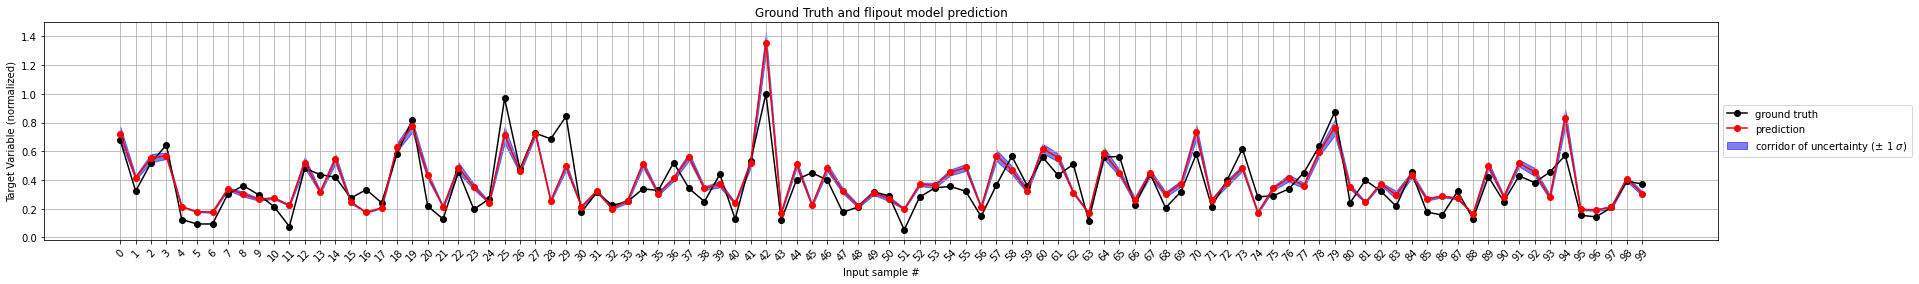

In [13]:
start_index = np.random.randint(test_data.shape[0]-150)
print('start_index \n ', start_index)

#random = range(start_index, start_index+100)
random_range = range(0, 100)

print('random range \n ', random_range)

test_labels_plot= np.asarray([float(test_labels[i]) for i in random_range])
print('test labels plot \n ', test_labels_plot)
mean_plot = np.asarray([float(pred_mean[i]) for i in random_range])
std_plot = np.asarray([float(pred_std[i]) for i in random_range])

print('unique value of predicted standard deviation \n ', np.unique(std_plot))

plot_gt_vs_pred(test_labels_plot, mean_plot, std_plot, path+'output_plots/'+uncert_name+'_vs_prediction', random_range, uncert_name)

## Plot explanation function

In [14]:
# code for horizontal bar chart 

def plot_explanation(grads_plot, feature_names, sample_number=None, err=None, save_file_path=None, combination_title=None, coff=None):
    plt.figure(figsize=(8, 5))
    #plt.barh(pos, vals, color=colors) #this code works well but does not have legend or text in int

    #print('grads_plot ', list(grads_plot))

    colors = ['C1' if x > 0 else 'C0' for x in list(grads_plot)] # originally negative=red and positive=green (coloring scheme)
    colors_set = set(colors)
    #print('colors_set before ', colors_set)
    colors_set = ['positive' if c == 'C1' else 'negative' for c in colors_set]
    #print('colors_set after ', colors_set)
    exp = list(grads_plot)
    pos = np.arange(len(exp)) + .5
    #print('pos values for plot are ', pos)

    vals = [float(x) for x in exp]
    vals_str = [str(round(val, 3)) for val in vals]
    #print('vals_str ', vals_str)

    #colors = ['r', 'g', 'b']
    labels = colors_set 
    legend_colors = list(set(colors))
    #print(legend_colors)
    handles = [plt.Rectangle((0,0),1,1, color=legend_colors[label]) for label in range(len(labels))]
    #print(handles)

    vals = [np.abs(num) if num  == 0 else num for num in vals] # removing the sign from 0 vals
    #print('vals ', vals)

    #max_horizontal_value_to_plot_text_box = np.max(vals)

    for i, v in enumerate(vals):
        if err is None:
            # in case the text box needs to be moved along the bar then switch 0 to v
            plt.text(v, i+0.5, str(round(v, 3)), Bbox = dict(facecolor = 'grey', alpha =0.2)) # https://www.geeksforgeeks.org/adding-value-labels-on-a-matplotlib-bar-chart/

        elif err is not None:
            # in case of the combined explanation, the text box should contain the mean+-std as well
            plt.text(v, i+0.7, str(round(v, 3))+'$\pm$'+str(round(err[i], 3)), Bbox = dict(facecolor = 'grey', alpha =0.2))

    axx = plt.barh([i for i in pos], vals, xerr=err, align='center', color=colors, alpha=0.75) # this code appropriate legend
    print('feature name ', feature_names)
    print('grads plot ', grads_plot)
    
    #zipper = zip(feature_names, grads_plot)

    #sorted_zipper = sorted(zipper)


    #feature_names, grads_plot = zip(*sorted_zipper)
    #print('feature name ', feature_names)
    #print('grads plot ', grads_plot) 

    plt.grid(alpha=0.5)
    plt.ylabel('feature names')
    plt.xlabel('feature coefficient')
    plt.yticks(pos, feature_names)

    if err is not None:
        error = plt.plot([], label='uncertainty ($\pm \sigma$)', linewidth=3, linestyle='-', color='k')
        print('combination title[0] ', combination_title[0])
        print('combination_title[1] ', combination_title[1])
        plt.title('combined explanation , prediction : '+str(combination_title[0])+'$\pm$'+str(combination_title[1]) + ', GT : ' + str(combination_title[2]))
        main_bars = [plt.Rectangle((0,0),1,1, color=legend_colors[label]) for label in range(len(labels))]
        #first_legend = plt.legend(handles=error)
        #second_legend = plt.legend(handles=main_bar)

        handles = error + main_bars #https://stackoverflow.com/questions/28732845/combine-two-pyplot-patches-for-legend       
        error_label = ['uncertainty ($\pm \sigma$)']
        main_bars_label = colors_set

        labels = error_label + main_bars_label
        plt.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
        #loc='upper center', bbox_to_anchor=(0.5, -0.05)

    else:
        handles=[plt.Rectangle((0,0),1,1, color=legend_colors[label]) for label in range(len(labels))]
        plt.title(f'Explanation id {sample_number}')
        plt.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1),ncol=2) # https://stackoverflow.com/questions/57340415/matplotlib-bar-plot-add-legend-from-categories-dataframe-column

    if coff:
        plt.ylabel('feature name')
        plt.title(f'{sample_number}')
        plt.xlabel('coefficient of variation ($\sigma$+$\epsilon$)/($\mu$+$\epsilon$)')
    
    plt.subplots_adjust()
    #plt.savefig(save_file_path+'_GBP.pdf', bbox_inches='tight')
    #plt.savefig(save_file_path+'_GBP.png', bbox_inches='tight')

## Compute GBP explanation

In [15]:
def guided_bp(test_input, test_label, layer_name, model, count):
    @tf.custom_gradient
    def guidedRelu(x):
        #https://towardsdatascience.com/how-to-visually-explain-any-cnn-based-models-80e0975ce57
        #https://www.coderskitchen.com/guided-backpropagation-with-pytorch-and-tensorflow/
        def grad(dy):
            return tf.cast(dy>0,'float32') * tf.cast(x>0, 'float32') * dy
        return tf.nn.relu(x), grad

    
    LAYER_NAME = layer_name

    # create a model till last convolutional layers to have the best compromise between high-level semantics and detailed spatial information
    gb_model = tf.keras.models.Model(inputs = [model.input],    
                                     outputs = [model.get_layer(LAYER_NAME).output])
    #print('list of gbp_model layer name : ')
    #for i in gb_model.layers:
    #    print('layer_name_ ', i.name)
    
    layer_dict = [layer for layer in gb_model.layers[1:] if hasattr(layer,'activation')]
    
    #value = model.get_layer(LAYER_NAME).output.shape[-1]  # to compute the number of channels in the volume at a particular layer 

    for layer in layer_dict:
        if layer.activation == tf.keras.activations.relu:
            layer.activation = guidedRelu
    
        
    #print('xxxxxxxxxxxxxxxxxxxxxxxxxx')
    #print('shape of example to be explained : \n' , test_input.shape)
    with tf.GradientTape() as tape:
        inputs = tf.cast(test_input, tf.float32)
        tape.watch(inputs)
        # NO NEED TO RUN THIS (the if condition) AS VISUALIZATION OF ENSEMBLE HEATMAPS FOR INNER LAYER WOULD MAKE NO SENSE : FILTER IN EVERY INDIVIDUAL ENSEMBLE UNIT WOULD LEARN SOMETHING DIFFERENT EVERYTIMG
        # THIS THESIS NEEDS TO FOCUS ON FINAL LAYER HEATMAPS (AS THEY SHOULD BE SAME FOR A GIVEN INPUT ACROSS ENSEMBLES)
                
        #outputs = gb_model.predict(inputs) 
        outputs = gb_model(inputs)
        
        # essentially model() and model.predict() yield the same output with the difference that 
        # https://stackoverflow.com/questions/55308425/difference-between-modelx-and-model-predictx-in-keras#:~:text=The%20format%20may%20be%20different,its%20structure%2C%20weights%20and%20biases.
        #Today given a model in tensorflow 2.0 (built using the keras library), #out_np = model.predict(x) provides a numpy array which can, as an example, be printed with print(out_np).
        #On the other hand,out_tf = model(x) results into a tensorflow object, wich can be converted to a numpy array with .numpy()


    #print('feature_names ', feature_names)
   #print('prediction ', outputs.numpy()[0][0])
    #print('GT :  ', test_label[0])
    print('outputs ', outputs)
    grads = tape.gradient(outputs, inputs)[0]# selecting that unit in dense layer that has the maximum activation for a given input,,,, if[0] not selected then shape of grads is: [1,32,32,3] 
    #print('grads p ', grads)

    grads = grads.numpy() #as the model(inputs) returns a tensor and this is eventually used in the gradient computation, for plotting purpose this needs to be converted in np

    # normalizing the value of computed gradient for each feature [04032022 update : no need to normalize the gradients as it is only useful for visualization in heatmap ]
    # in bar charts, the gradients can remain negative 
    #grads -= np.min(grads)
    #grads /= np.max(grads)
    
    
    #plot_explanation(grads_plot=grads, 
    #                 feature_names=feature_names,
    #                 sample_number=i, 
    #                 err=None, 
    #                 save_file_path=path+'output_plots/explanation_for_sample_number_'+str(i)+'_input_id_'+str(sample_id))   


    #print('feature_weight_list : ', feature_weight_list_for_single_input)
    #feature_weight_arr =  np.asarray(feature_weight_list_for_single_input)
    #feature_weight_for_single_input = np.reshape(feature_weight_arr, (num_samples_explanations_to_be_generated, -1))
    # the mean and the std of the different explanations of the samples is computed here 
    #mean_feature_weight = np.mean(feature_weight_arr, axis=0)
    #std_feature_weight = np.std(feature_weight_arr, axis=0)

    #print(mean_feature_weight)
    #print(std_feature_weight)
    
    #print('len of outputs : ', len(list_of_outputs))
    #mean_output = np.mean(list_of_outputs)
    #std_output = np.std(list_of_outputs)

    #print('mean output shape ', mean_output.shape)
    #print('std output shape ', std_output.shape)

    #mean_output = str(round(mean_output, 3))
    #std_output = str(round(std_output, 3))
    #test_label = str(round(float(test_label), 3))

    #print('mean_output ', mean_output)
    #print('std_output ', std_output)
    #print('test_label ', test_label)

    #plot_explanation(grads_plot=mean_feature_weight,
    #                 feature_names=feature_names, 
    #                 sample_number=None,
    #                 err=std_feature_weight,
    #                 save_file_path=path+'output_plots/combined_explanation_of_'+str(num_samples_explanations_to_be_generated)+'_samples_for_input_id_'+str(sample_id),
    #                 combination_title=[mean_output, std_output, test_label])
    
    #return mean_feature_weight, std_feature_weight, feature_weight #returning feature_weight in order to visualize and analyse the behaviour of distribution
    return grads, outputs

In [16]:
# Analysis of the input 
print('train data \n ', train_data[0])
print('feature names \n ', feature_names)

#model.summary()

#test_sample_index=np.random.randint(3000)
#test_input_temp = test_data[test_sample_index]
#test_input = np.expand_dims(test_input_temp, axis=0)
#test_label = test_labels[test_sample_index]
#print('test_input shape :', test_input.shape)


list_of_inputs_to_be_explained = [] 
list_of_inputs_gt = []

list_of_gbp_explanation = [] 
list_of_gbp_outputs = [] 

count = 0 
start_index=1
#number_of_inputs_to_be_explained = test_data.shape[0]
number_of_inputs_to_be_explained = 1
number_of_explanations_per_input = 10

start = time.time()

for input, label in tqdm(zip(test_data[start_index:], test_labels[start_index:])):
    input = np.expand_dims(input, axis=0)  
      
    if count<number_of_inputs_to_be_explained:
        print(input)
        print(label)
        count += 1
        list_of_gbp_explanation_single_input = [] 
        list_of_gbp_outputs_single_image = [] 
        
        for i in range(number_of_explanations_per_input):
            #print(f'Generating explanation # {i} for input number #{count}')
            gbp_explanation, gbp_output = guided_bp(input,
                                                    label, 
                                                    'flipout_dense',
                                                    stochastic_model, 
                                                    count=count)
        
            list_of_gbp_explanation_single_input.append(gbp_explanation)
            list_of_gbp_outputs_single_image.append(gbp_output)
            
        list_of_gbp_explanation.append(list_of_gbp_explanation_single_input)
        list_of_gbp_outputs.append(list_of_gbp_outputs_single_image)
        list_of_inputs_to_be_explained.append(input)
        list_of_inputs_gt.append(label)
        #print('xxxxxxxxxxxxxxxxxxxxxxxxxx')
        #print('xxxxxxxxxxxxxxxxxxxxxxxxxx')
            
    else:
        break 

end = time.time()                                                         

train data 
  [0.19023398 0.55579171 1.         0.10391459 0.16620112 0.05353289
 0.15984213 0.16943215]
feature names 
  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']


0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
1it [00:00,  5.56it/s]

[[0.60681115 0.18162393 0.82352941 0.04940218 0.05685804 0.06739313
  0.05580357 0.21372809]]
[0.32251241]
outputs  tf.Tensor([[0.45126265]], shape=(1, 1), dtype=float32)
outputs  tf.Tensor([[0.41445082]], shape=(1, 1), dtype=float32)
outputs  tf.Tensor([[0.43314722]], shape=(1, 1), dtype=float32)
outputs  tf.Tensor([[0.4235023]], shape=(1, 1), dtype=float32)
outputs  tf.Tensor([[0.43591535]], shape=(1, 1), dtype=float32)
outputs  tf.Tensor([[0.41091907]], shape=(1, 1), dtype=float32)
outputs  tf.Tensor([[0.45043525]], shape=(1, 1), dtype=float32)
outputs  tf.Tensor([[0.4296454]], shape=(1, 1), dtype=float32)
outputs  tf.Tensor([[0.3452548]], shape=(1, 1), dtype=float32)
outputs  tf.Tensor([[0.4330579]], shape=(1, 1), dtype=float32)


## Save test input and label data

In [17]:
print('total time (mins) ', (end-start)/60)

# saving the batch of input to be explained 
np.save(os.path.join(explanation_path, f'GBP_list_of_inputs_to_be_explained.npy'),
        list_of_inputs_to_be_explained,
        allow_pickle=True)

# saving the labels for batch of input to be explained 
np.save(os.path.join(explanation_path, f'GBP_list_of_inputs_gt.npy'),
        list_of_inputs_gt,
        allow_pickle=True)

total time (mins)  0.003216699759165446


## Save GBP explanation

In [18]:
#save the explanation 
np.save(os.path.join(explanation_path, f'list_of_gbp_explanation.npy'),
        list_of_gbp_explanation,
        allow_pickle=True)

#save the model prediction 
np.save(os.path.join(explanation_path, f'list_of_gbp_outputs.npy'),
        list_of_gbp_outputs,
        allow_pickle=True)

## Test the quality of generated GBP explanation (sample few images and view the explanation)

inputs shape  (1, 1, 8)
gt_labels shape  (1, 1)
gbp_explanatios shape  (1, 10, 8)
list_of_gbp_outputs  (1, 10, 1, 1)


  0%|          | 0/1 [00:00<?, ?it/s]

inputs [0] :  [[0.60681115 0.18162393 0.82352941 0.04940218 0.05685804 0.06739313
  0.05580357 0.21372809]]
gt :  [0.32251241]
Input ID :  -1



 20%|██        | 2/10 [00:00<00:00, 19.98it/s]

feature name  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
grads plot  [-0.1960574  -0.17919703  0.43911636 -0.00106287 -0.2058173  -0.3542025
  0.8715437   0.7803463 ]
feature name  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
grads plot  [-0.1502031  -0.13901396  0.3862919  -0.02776596 -0.19997263 -0.29477647
  0.7819172   0.6976925 ]
feature name  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
grads plot  [-1.8030530e-01 -1.7170852e-01  4.2285678e-01  4.4199824e-04
 -1.9889176e-01 -3.4211683e-01  8.4474826e-01  7.4996030e-01]
feature name  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_valu


 50%|█████     | 5/10 [00:00<00:00, 22.22it/s]

feature name  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
grads plot  [-0.1491794  -0.17125542  0.41555035  0.01523978 -0.19219273 -0.34594655
  0.8479341   0.72716403]



 80%|████████  | 8/10 [00:00<00:00, 22.73it/s]

feature name  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
grads plot  [-0.17911074 -0.16245317  0.38814205  0.00455964 -0.17782637 -0.31651765
  0.7664418   0.6875742 ]
feature name  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
grads plot  [-0.2146281  -0.22135091  0.45573366  0.06107998 -0.1769732  -0.40704358
  0.89554036  0.7802127 ]
feature name  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
grads plot  [-0.15847546 -0.1696992   0.4111064   0.01166442 -0.19009966 -0.33995104
  0.83188635  0.7220565 ]
feature name  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
grads plot  [-0.111

100%|██████████| 10/10 [00:00<00:00, 21.99it/s]

feature name  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
grads plot  [-0.16668062 -0.14711875  0.41335428 -0.03491697 -0.21582247 -0.31204706
  0.8329732   0.7496774 ]
mean explanation :  [-0.16938514 -0.16363867  0.4024046   0.00165375 -0.1889765  -0.3263796
  0.80528486  0.71287996]
std explanation :  [0.02757081 0.03351644 0.04217755 0.03306278 0.01608123 0.05081839
 0.08079025 0.06508363]



100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


feature name  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
grads plot  [-0.16938514 -0.16363867  0.4024046   0.00165375 -0.1889765  -0.3263796
  0.80528486  0.71287996]
combination title[0]  0.423
combination_title[1]  0.029


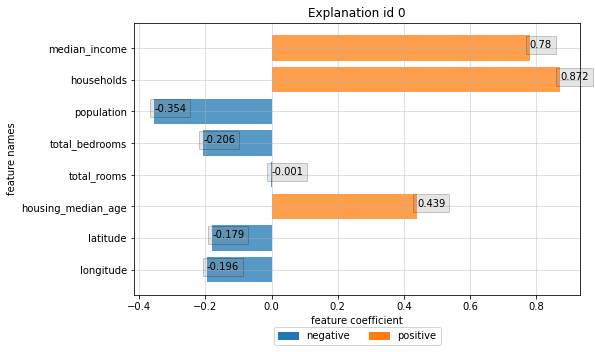

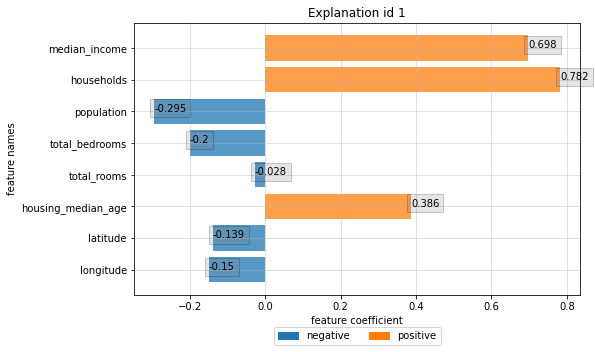

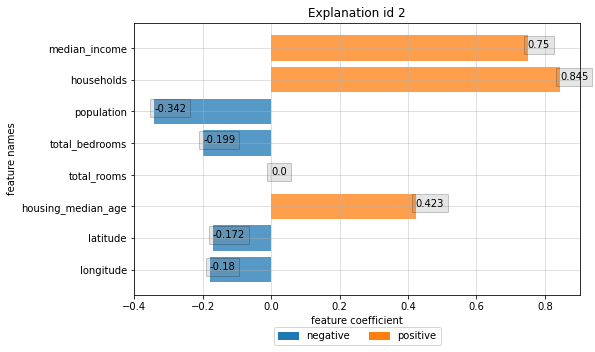

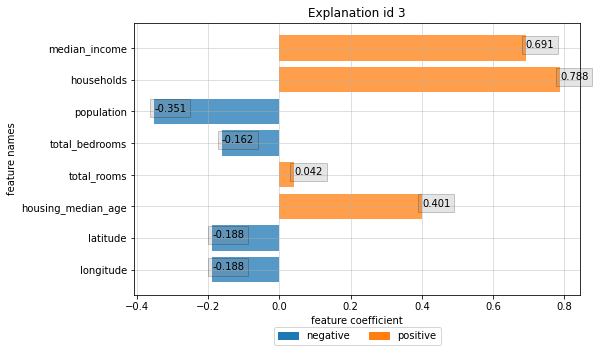

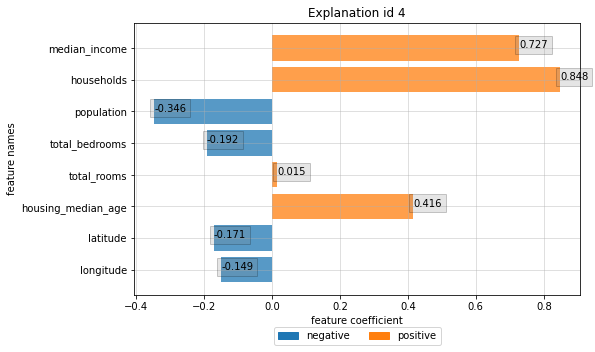

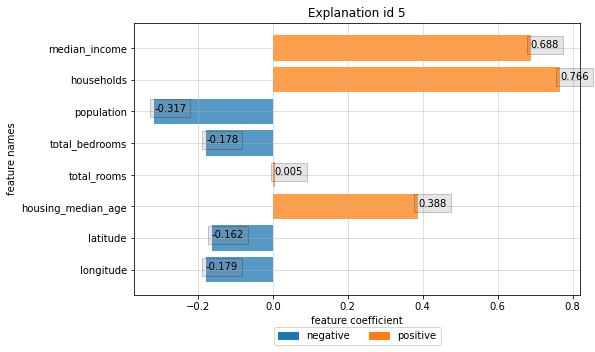

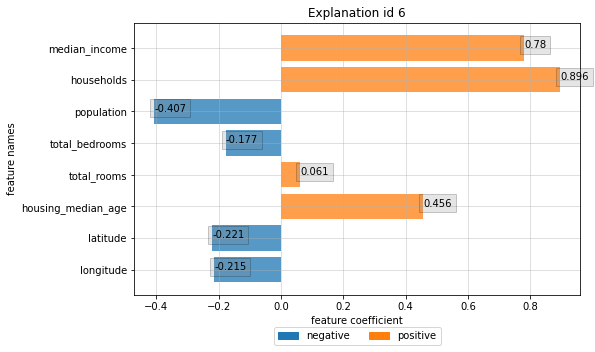

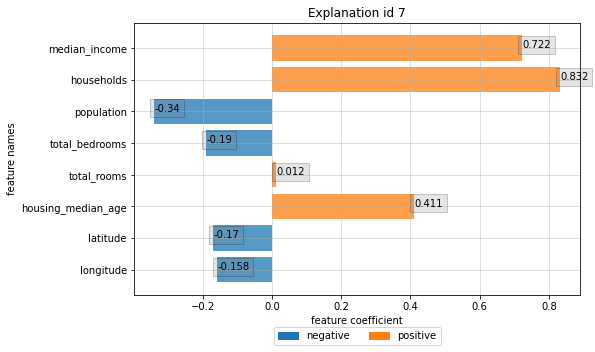

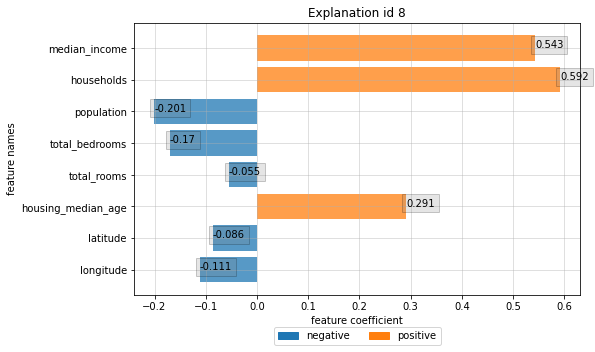

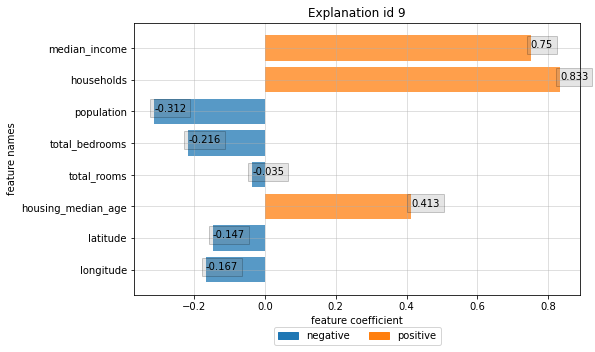

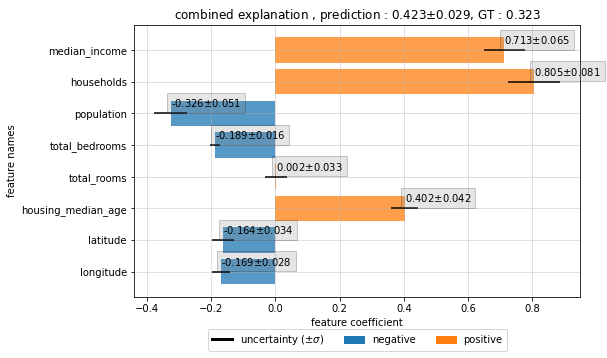

In [19]:
inputs = np.load(os.path.join(explanation_path, f'GBP_list_of_inputs_to_be_explained.npy'))
print('inputs shape ', inputs.shape)

gt_labels = np.load(os.path.join(explanation_path, f'GBP_list_of_inputs_gt.npy'))
print('gt_labels shape ', gt_labels.shape)

gbp_explanations = np.load(os.path.join(explanation_path, f'list_of_gbp_explanation.npy'))
print('gbp_explanatios shape ', gbp_explanations.shape)

list_of_gbp_outputs = np.load(os.path.join(explanation_path, f'list_of_gbp_outputs.npy'))
print('list_of_gbp_outputs ', list_of_gbp_outputs.shape)

inputs_to_be_displayed = 1
accumulator = []

for exp in tqdm(range(inputs_to_be_displayed)):
    print('inputs [0] : ', inputs[0])
    print('gt : ', gt_labels[0])
    idx = random.randint(0, inputs.shape[0])
    print('Input ID : ', idx-1) 
    feature_names = feature_names

    for j in tqdm(range(number_of_explanations_per_input)):
        grads_plot = gbp_explanations[idx-1, j, :]
        #print(grads_plot.shape)
        #print(grads_plot)
        plot_explanation(grads_plot, 
                         feature_names, 
                         sample_number=j, 
                         err=None, 
                         save_file_path=explanation_heatmap_path+'/input_id_'+str(idx-1)+'_explanation_instance_'+str(j), 
                         combination_title=None)
        accumulator.append(grads_plot)
    
    accumulator_arr = np.array(accumulator) 
    #extract feature weights 
    #input_explanation = gbp_explanations[exp]
    prediction = list_of_gbp_outputs[exp]

    #calculate mean of the feature weights 
    mean_explanation = np.mean(accumulator_arr, axis=0)

    # calculate std of the feature weights 
    #std_explanation = np.std(input_explanation, axis=0)
    std_explanation = np.std(accumulator_arr, axis=0)

    print('mean explanation : ', mean_explanation) 
    print('std explanation : ', std_explanation) 


    stabilizer = 1e-3
    coefficient_of_variation = (std_explanation+stabilizer)/(mean_explanation+stabilizer)

    mean_prediction = np.mean(prediction)
    mean_prediction_rounded = round(mean_prediction, 3)
    #print('mean prediction rounded ', mean_prediction_rounded)

    std_prediction = np.std(prediction)
    std_prediction_rounded = round(std_prediction, 3)

    #print(list_of_inputs_gt[exp])
    ground_truth = round(list_of_inputs_gt[exp][0], 3)

    
    plot_explanation(mean_explanation, 
                     feature_names, 
                     sample_number=exp, 
                     err=std_explanation, #
                     save_file_path=explanation_heatmap_path+'/input_id_'+str(idx-1)+'_combined_exp',
                     combination_title=[mean_prediction_rounded, std_prediction_rounded, ground_truth])
    
    #print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')
    #print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')

## Coefficient of Variation

coefficient_of_variation  [-0.16967537033178362, -0.2122277414492641, 0.10703285508034469, 12.83572803655671, -0.09086895070117722, -0.15925519483167908, 0.10144088743239228, 0.0925696678398359]
feature name  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
grads plot  [-0.16967537033178362, -0.2122277414492641, 0.10703285508034469, 12.83572803655671, -0.09086895070117722, -0.15925519483167908, 0.10144088743239228, 0.0925696678398359]


<Figure size 576x360 with 0 Axes>

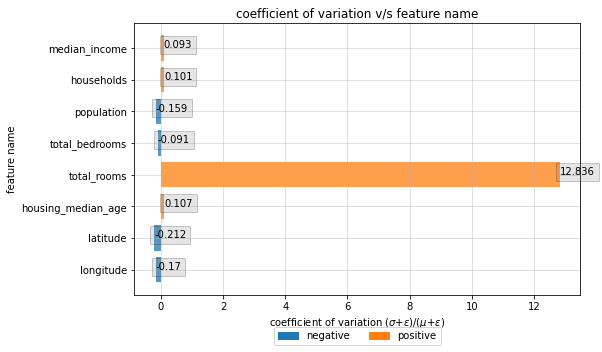

In [20]:
eps=0.001
# compute coefficient of variation 
coefficient_of_variation = [(i+eps)/(j+eps) for i,j in zip(std_explanation, mean_explanation)]
print('coefficient_of_variation ', coefficient_of_variation)

plt.figure(figsize=(8, 5))
colors = ['C1' if x > 0 else 'C0' for x in list(coefficient_of_variation)] # originally negative=red and positive=green (coloring scheme)
colors_set = set(colors)
legend_colors = list(set(colors))
colors_set = ['positive' if c == 'C1' else 'negative' for c in colors_set]

bars = [plt.Rectangle((0,0),1,1, color=legend_colors[label]) for label in range(len(colors_set))]
#uncomment the next 2 line in case cv threshold is needed 
#thresh = plt.plot([], label='threshold', linewidth=3, linestyle='-', color='k')
#handles = bars + thresh

main_bars_label = colors_set

# uncomment following two lines in case cv threshold is needed
#error_label = ['threshold']
#labels = main_bars_label + error_label 

# uncomment following two lines to remove threshold
handles = bars 
labels = main_bars_label


'''
plt.bar(feature_names[:-1], coefficient_of_variation, color=colors, alpha=0.75)

# uncomment the following 2 lines to get the threshold lines
#plt.plot(feature_names[:-1], [30]*len(feature_names[:-1]), '--k')
#plt.plot(feature_names[:-1], [-30]*len(feature_names[:-1]), '--k')
plt.xticks(rotation=90)
plt.xlabel('feature name')
plt.ylabel(r'coefficient of variation : ($\sigma$ + $\epsilon$)/ ($\mu$ + $\epsilon$ )')
plt.grid(alpha=0.5) 


plt.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.475), ncol=2)
plt.title('feature name v/s coefficient of variation')

for i, v in enumerate(coefficient_of_variation):
    # in case the text box needs to be moved along the bar then switch 0 to v
    plt.text(i-0.2, v, str(round(v, 3)), Bbox = dict(facecolor = 'grey', alpha =0.2)) # https://www.geeksforgeeks.org/adding-value-labels-on-a-matplotlib-bar-chart/
'''
plot_explanation(coefficient_of_variation, 
                     feature_names, 
                     sample_number="coefficient of variation v/s feature name", 
                     
                     save_file_path=explanation_heatmap_path+'/input_id_'+str(idx-1)+'_combined_exp',
                     combination_title='coefficient of variation',
                     coff=True)

In [21]:
#list_of_gbp_exp = [] 
#list_of_component_output = [] 

#for test_sample_index in index_of_most_extreme_inputs_to_predict:

#    gbp_exp = [] 
#    component_output = [] 


#    test_input = np.expand_dims(test_data[test_sample_index, :], axis=0)
#    print('input to be explained \n ', test_input)

#    for i in range(number_of_explanations_per_image):
        
#        gb_model = make_guided_bp_model(model[i])
#        sample_exp, sample_outp = guided_bp(test_input, gb_model)
#        gbp_exp.append(sample_exp)
#        component_output.append(sample_outp)
#        plot_explanation(sample_exp.squeeze(axis=0),  # pass explanation as list 
#                        feature_names, 
#                        sample_number=i, 
#                        err=None, 
#                        save_file_path=path+'output_plots/explanation_for_component_number_'+str(i)+'_input_id_'+str(test_sample_index)+'_'+difficulty,
#                        combination_title=None)
#        print('-------------------------------')

#    list_of_gbp_exp.append(gbp_exp)
#    list_of_component_output.append(component_output)
#    print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')

In [22]:
'''
list_of_mean_of_feature_exp = [] 
list_of_std_of_feature_exp = [] 

list_of_mean_of_predictions = [] 
list_of_std_of_predictions = [] 

for i in range(len(list_of_gbp_exp)):  
    
    gbp_exp_arr_temp = np.array(list_of_gbp_exp[i])
    gbp_exp_arr = np.reshape(gbp_exp_arr_temp, (-1, 8))
    print(gbp_exp_arr.shape)

    print('gbp exp \n ', list_of_gbp_exp[i])
    # appending mean annnd std of the feature explanation for an individual input
    mean_of_feature_exp = np.mean(gbp_exp_arr, axis=0)
    list_of_mean_of_feature_exp.append(mean_of_feature_exp)

    std_of_feature_exp = np.std(gbp_exp_arr, axis=0) 
    list_of_std_of_feature_exp.append(std_of_feature_exp)

    print('mean exp \n ', mean_of_feature_exp)
    print('std exp \n ', std_of_feature_exp)

    #print('feature names :\n  ', feature_names)
    component_output_arr_temp = np.array(list_of_component_output[i])
    component_output_arr = np.reshape(component_output_arr_temp, (-1, 1))

    print('component_output \n', list_of_component_output[i])
    print('component_output shape : \n', len(list_of_component_output[i]))

    # appending the mean and std of the prediction for an individual input 
    mean_of_predictions = np.mean(component_output_arr, axis=0)
    list_of_mean_of_predictions.append(mean_of_predictions)

    std_of_predictions = np.std(component_output_arr, axis=0)
    list_of_std_of_predictions.append(std_of_predictions) 


    mean_of_predictions = str(round(float(mean_of_predictions), 3))
    std_of_predictions = str(round(float(std_of_predictions), 3))

    ground_truth = str(round(float(list_of_gt[i]), 3))

    print('mean_of_predictions \n ', mean_of_predictions)
    print('std_of_prediction \n ', std_of_predictions)
    print('gt \n ', ground_truth)

    plot_explanation(mean_of_feature_exp,  # pass explanation as list 
                    feature_names, 
                    sample_number=i, 
                    err=std_of_feature_exp, 
                    save_file_path=path+'output_plots/combined_explanation_of_'+str(component_output_arr.shape[0])+'_samples_for_input_id_'+str(index_of_most_extreme_inputs_to_predict[i])+'_'+difficulty,
                    combination_title=[mean_of_predictions, std_of_predictions, ground_truth])
    print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')
'''

"\nlist_of_mean_of_feature_exp = [] \nlist_of_std_of_feature_exp = [] \n\nlist_of_mean_of_predictions = [] \nlist_of_std_of_predictions = [] \n\nfor i in range(len(list_of_gbp_exp)):  \n    \n    gbp_exp_arr_temp = np.array(list_of_gbp_exp[i])\n    gbp_exp_arr = np.reshape(gbp_exp_arr_temp, (-1, 8))\n    print(gbp_exp_arr.shape)\n\n    print('gbp exp \n ', list_of_gbp_exp[i])\n    # appending mean annnd std of the feature explanation for an individual input\n    mean_of_feature_exp = np.mean(gbp_exp_arr, axis=0)\n    list_of_mean_of_feature_exp.append(mean_of_feature_exp)\n\n    std_of_feature_exp = np.std(gbp_exp_arr, axis=0) \n    list_of_std_of_feature_exp.append(std_of_feature_exp)\n\n    print('mean exp \n ', mean_of_feature_exp)\n    print('std exp \n ', std_of_feature_exp)\n\n    #print('feature names :\n  ', feature_names)\n    component_output_arr_temp = np.array(list_of_component_output[i])\n    component_output_arr = np.reshape(component_output_arr_temp, (-1, 1))\n\n    prin